In [ ]:
! pip install --quiet langdetect
! pip install networkx

In [1]:
from pyspark.sql import SparkSession, Row

spark = SparkSession \
    .builder \
    .appName("Retweet Regression Data") \
    .config("spark.jars", "/home/jovyan/work/gcs-connector-hadoop2-latest.jar") \
    .config("spark.hadoop.fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
    .config("spark.hadoop.google.cloud.auth.service.account.enable", "true") \
    .config("spark.hadoop.google.cloud.auth.service.account.json.keyfile", "/home/jovyan/work/key.json") \
    .config("spark.driver.memory", "22g") \
    .config("spark.driver.maxResultSize", "12g") \
    .config("spark.executor.memory", "3g") \
    .getOrCreate()

In [2]:
from datetime import datetime

tweets = spark.read.parquet('gs://spain-tweets-warehouse')

tweets = tweets \
    .where(tweets.datestamp >= datetime(2017,8,1)) \
    .where(tweets.datestamp < datetime(2017,8,2))

In [3]:
tweets.createOrReplaceTempView('tweets')
tweets.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- features: struct (nullable = true)
 |    |    |    |    |-- all: struct (nullable = true)
 |    |    |    |    |    |-- tags: array (nullable = true)
 |    |    |    |    |    |    |-- element: struct (containsNull = true)
 |    |    

In [4]:
from langdetect import detect_langs
from langdetect.lang_detect_exception import LangDetectException
from itertools import permutations

def confident_lang(text):
    try: 
        langs = detect_langs(text)
        top = langs[0]
        if top.prob > 0.75:
            return top.lang
        elif top.lang == 'cat' or top.lang == 'es':
            # print(f'could not find language.\n Probs: {langs}.\n Text: {text}')
            return None
        else:
            return None
    except LangDetectException:
        return None


def sum_langs(a, b):
    for lang, cnt in b.items():
        try:
            a[lang] += cnt
        except KeyError:
            a[lang] = cnt
    return a

def user_lang(di):
    """Picks the language of the user

    :param di: dictionary of language-> percentage
    :returns: language picked for user, as a string
    
    Examples
    --------
    >>> user_lang({ 'es': .7, 'en': .3 })
    es

    """
    if di.get('ca', 0) > 0.10:
        return 'ca'
    
    lang,val = None,0

    for k,v in di.items():
        if v > val:
            lang,val = k,v

    return lang

def create_user(di):
    retweets = sum(di.values())
    pmf = {k:v/retweets for k,v in di.items()}
    lang = user_lang(di)
    return (lang, retweets)


def user_stats(user_info, user_networks, users, user):

    # this allows network to be decoupled from this stage
    network = user_networks[user]
    relevant = [(u, user_info[u]) for u in users if u in network]

    get_lang = lambda lang: [id_ for id_, (lang, _) in relevant
                             if lang == lang]

    # compute wanted stats:
    tot_engaged = len(relevant)
    tot_cat_engaged = len(get_lang('cat'))
    net_size = len(network)
    user_lang, _ = user_info[user]

    return user, user_lang, tot_engaged, tot_cat_engaged, net_size


def get_stats_for_users(user_info, user_networks, tweet, lang, users):
    stats = [user_stats(user_info, user_networks, users, user)
             for user in users]

    # TODO: add tweet language...
    stats = [(tweet, lang) + s for s in stats]
    return stats


In [5]:
# NOTE: not getting extended text!!!
# text should not be used for anything!!
query = """
SELECT retweeted_status.id AS id, 
       retweeted_status.text as text,
       user.id AS user
FROM tweets 
WHERE retweeted_status IS NOT NULL
"""

df = spark.sql(query)
df.printSchema()

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- user: long (nullable = true)



In [6]:
partitions = int(df.rdd.getNumPartitions() * 4)

tweets = df.rdd \
           .repartition(partitions) \
           .map(lambda x: x.asDict(True)) \
           .map(lambda d: {**d, 'lang': confident_lang(d['text'])}) \
           .filter(lambda d: d['lang'] is not None) \
           .cache()

In [ ]:
user_info = tweets \
    .map(lambda d: (d['user'], d)) \
    .mapValues(lambda d: {d['lang']: 1}) \
    .reduceByKey(sum_langs) \
    .mapValues(create_user) \
    .collectAsMap()

In [ ]:
partitions = int(tweets.getNumPartitions() / 16)
partitions = max(partitions, 64)

tweet_users = tweets \
    .map(lambda d: (d['id'], {'id': d['id'], 'lang': d['lang'], 'users': [d['user']], 'count': 1})) \
    .coalesce(partitions) \
    .reduceByKey(lambda a,b: {**a, 
                              'users': a['users'] + b['users'], 
                              'count': a['count'] + b['count']}) \
    .map(lambda t: t[1]) \
    .filter(lambda t: t['count'] > 1) \
    .cache()

In [ ]:
user_networks = tweet_users \
    .flatMap(lambda d: permutations(d['users'], 2)) \
    .map(lambda t: (t[0], set([t[1]]))) \
    .repartition(partitions) \
    .reduceByKey(lambda a,b: a | b) \
    .collectAsMap()

In [21]:
import sys

sum([sys.getsizeof(v) for v in user_networks.values()]) / 1024/ 1024 / 1024

21.607688188552856

In [ ]:
RegressionData = Row('id', 'lang', 'user', 'user_lang', 'engaged', 'cat_engaged', 'net_size')

bc_ui = spark.sparkContext.broadcast(user_info)
bc_un = spark.sparkContext.broadcast(user_networks)

reg_data = tweet_users \
    .flatMap(lambda d: get_stats_for_users(bc_ui.value, bc_un.value, d['id'], d['lang'], d['users'])) \
    .map(lambda t: RegressionData(*t)) \
    .toDF()

In [45]:
bc_ui = spark.sparkContext.broadcast(user_info)

In [ ]:
reg_data = pd.DataFrame(reg_data)

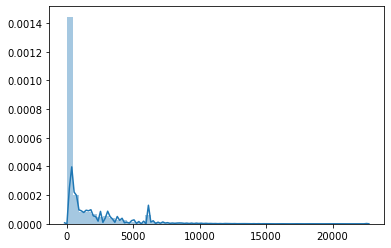

In [27]:
import numpy as np
import seaborn as sns

edges = np.array([len(v) for v in user_networks.values()])
sns.distplot(edges)